In [60]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

import datetime as dt
from datetime import timezone, timedelta

In [61]:
site_code = '08040600'
forecast_length = 6

In [62]:
timezone_offset = -5.0  # Eastern Standard Time (UTC−08:00)
tzinfo = timezone(timedelta(hours=timezone_offset))
current_dateTime = datetime.now(tzinfo)

In [63]:
begin_date = '2024-08-12T00:00:00.000-05:00'
#end_date = '2024-08-14T11:00:00.000-05:00'
end_date = current_dateTime.strftime('%Y-%m-%dT%H:%M:%S.%f%z')


In [64]:
print(end_date)

2024-11-11T16:41:43.908913-0500


In [65]:
print(current_dateTime.strftime('%Y-%m-%dT%H:%M:%S.%f%z'))

2024-11-11T16:41:43.908913-0500


In [66]:
#print(end_date)

In [67]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=08040600&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=27)
gage = gage.iloc[1: , :]

In [68]:
gage

,agency_cd,site_no,datetime,tz_cd,139689_00065,139689_00065_cd,253755_00065,253755_00065_cd
1,USGS,08040600,2024-08-11 23:00,CDT,65.02,P,65.02,P
2,USGS,08040600,2024-08-11 23:15,CDT,65.02,P,65.02,P
3,USGS,08040600,2024-08-11 23:30,CDT,65.00,P,65.00,P
4,USGS,08040600,2024-08-11 23:45,CDT,65.01,P,65.01,P
5,USGS,08040600,2024-08-12 00:00,CDT,65.00,P,65.00,P
...,...,...,...,...,...,...,...,...
8500,USGS,08040600,2024-11-11 14:00,CST,53.01,P,NaN,NaN
8501,USGS,08040600,2024-11-11 14:15,CST,53.06,P,NaN,NaN
8502,USGS,08040600,2024-11-11 14:30,CST,53.10,P,NaN,NaN
8503,USGS,08040600,2024-11-11 14:45,CST,53.14,P,NaN,NaN


In [69]:
gage['139689_00065'] = gage['139689_00065'].astype(float)
gage = gage[['datetime','139689_00065']]
gage = gage.set_index('datetime')
gage['item_id'] = 'gage'
gage  = gage.rename(columns={"139689_00065": "series"})
gage.head()

,series,item_id
datetime,,
2024-08-11 23:00,65.02,gage
2024-08-11 23:15,65.02,gage
2024-08-11 23:30,65.00,gage
2024-08-11 23:45,65.01,gage
2024-08-12 00:00,65.00,gage


In [70]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=08040600&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=27)
flow = flow.iloc[1: , :]

In [71]:
flow

,agency_cd,site_no,datetime,tz_cd,139690_00060,139690_00060_cd
1,USGS,08040600,2024-08-11 23:00,CDT,15000,P
2,USGS,08040600,2024-08-11 23:15,CDT,15000,P
3,USGS,08040600,2024-08-11 23:30,CDT,15000,P
4,USGS,08040600,2024-08-11 23:45,CDT,15000,P
5,USGS,08040600,2024-08-12 00:00,CDT,15000,P
...,...,...,...,...,...,...
8577,USGS,08040600,2024-11-11 14:00,CST,4460,P
8578,USGS,08040600,2024-11-11 14:15,CST,4500,P
8579,USGS,08040600,2024-11-11 14:30,CST,4530,P
8580,USGS,08040600,2024-11-11 14:45,CST,4570,P


In [72]:
flow['139690_00060'] = flow['139690_00060'].astype(float)
flow = flow[['datetime','139690_00060']]# Merge datasets together on datetime index and check if everything is good
flow = flow.set_index('datetime')
flow['item_id'] = 'flow'

            
#df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
#df.head()
flow  = flow.rename(columns={"139690_00060": "series"})

flow.head()

,series,item_id
datetime,,
2024-08-11 23:00,15000.0,flow
2024-08-11 23:15,15000.0,flow
2024-08-11 23:30,15000.0,flow
2024-08-11 23:45,15000.0,flow
2024-08-12 00:00,15000.0,flow


In [73]:
merge = pd.concat([gage, flow])

In [74]:
merge

,series,item_id
datetime,,
2024-08-11 23:00,65.02,gage
2024-08-11 23:15,65.02,gage
2024-08-11 23:30,65.00,gage
2024-08-11 23:45,65.01,gage
2024-08-12 00:00,65.00,gage
...,...,...
2024-11-11 14:00,4460.00,flow
2024-11-11 14:15,4500.00,flow
2024-11-11 14:30,4530.00,flow


In [75]:
merge.reset_index(inplace=True)

#merge

In [76]:
test_data = TimeSeriesDataFrame.from_data_frame(merge, id_column="item_id", timestamp_column='datetime') #, timestamp_column=merge.index
test_data = test_data.convert_frequency(freq='H', agg_numeric="max")
test_data.head()

series
item_id timestamp                  
gage    2024-08-11 23:00:00   65.02
        2024-08-12 00:00:00   65.01
        2024-08-12 01:00:00   65.02
        2024-08-12 02:00:00   65.02
        2024-08-12 03:00:00   65.01

In [77]:
prediction_length = 6

In [78]:
predictor = TimeSeriesPredictor.load("rio_hondo_gage_autogluon_"+str(prediction_length), require_version_match=False)

In [79]:
predictions = predictor.predict(test_data)

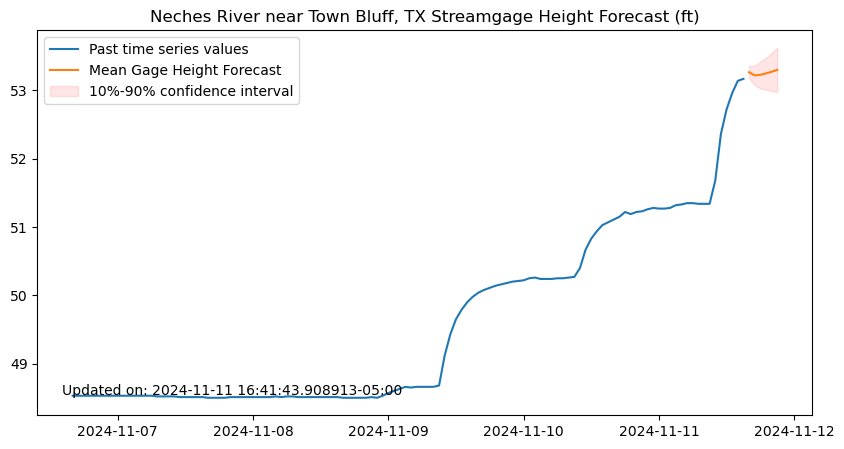

In [80]:
item_id = 'gage'

plt.figure(figsize=(10, 5))
plt.title('Neches River near Town Bluff, TX Streamgage Height Forecast (ft)')


y_past = test_data.loc[item_id]
y_pred = predictions.loc[item_id]

plt.plot(y_past[-120:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean Gage Height Forecast")
#plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
#plt.figtext(0.5, 0.01, "Note: Route 23 Typically Closes At Gage Height Of 18 feet", ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.figtext(0.15, 0.15, 'Updated on: '+str(current_dateTime), ha='left', fontsize=10)
plt.legend(loc = 'upper left');
plt.savefig('static/'+item_id+'_rio-hondo-gage-forecast.png')

In [81]:
y_pred[['mean', '0.1', '0.9']]

,mean,0.1,0.9
timestamp,,,
2024-11-11 16:00:00,53.266404,53.183820,53.356443
2024-11-11 17:00:00,53.220019,53.077919,53.362968
2024-11-11 18:00:00,53.229035,53.029456,53.421188
2024-11-11 19:00:00,53.250024,53.011301,53.475848
2024-11-11 20:00:00,53.273436,52.991295,53.552599
2024-11-11 21:00:00,53.301371,52.978326,53.624850


In [82]:
print(current_dateTime)

2024-11-11 16:41:43.908913-05:00
